In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data
from fooof.utils.params import compute_knee_frequency
from pathlib import Path
import glob
from math import floor
import math
import sys
from scipy import stats
import random
from scipy.interpolate import make_interp_spline, BSpline
import random

sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/Aperiodic_sleep_paper/helpers/")
from utils import resample_stages
from plots import plot_event_related_lines

# Adjust paths

In [2]:
# get all FOOOF files
path_files = '/home/b1044271/Columbia/Results/Time-resolved/E257/*.npy'
aperiodic_files = glob.glob(path_files)

# get all Sleep staging files
staging_files = '/home/b1044271/EEGsleep/SleepStaging/*.txt'
stage_files = glob.glob(staging_files)

# Adjust sampling rate of stages

In [3]:
# ADJUST Sampling rate of sleep stages
sfiles = np.zeros([17,50000])*np.nan
i=0
for X in stage_files:
    x  = resample_stages(X, 2)
    sfiles[i,0:len(x)] = x
    i=i+1

# Settings

In [4]:
# SET parameters of estimation
t          = 2 #time window we use for FOOOF
intrvl     = 30 #length of the intercal we want to look at before and after transition point (in datapoints)
b          = [1,2,3] #NREM stages
time_range = 60 # range of the whole epoch to be plotted (in sec)

## set which file to use

In [5]:
# Exponent of KNEE MODEL
A = np.load(aperiodic_files[6])

# Exponent of FIXED MODEL
#A = np.load(aperiodic_files[5])

# KNEE Frequency of KNEE MODEL
#A1 = np.load(aperiodic_files[6])
#A2 = np.load(aperiodic_files[9])
#A = compute_knee_frequency(A1,A2)

/home/b1044271/anaconda3/envs/mne/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Adjust knee freq (skip if use exp)]

# N2-N2 vs N2-N3 TRANSITIONS

In [29]:
i = 0

N23m_a = np.zeros([17,time_range])*np.nan
N22m_a = np.zeros([17,time_range])*np.nan  # 30 data pooints means 30*2 = 60s should be centered at the time of transition
trials = np.zeros(17)*np.nan

random.seed(0)
for x in np.arange(17):
    Stage = sfiles[x][~np.isnan(sfiles[x])] # load sleep stages
    param = A[x] # load parameter array
        
    # This section deals with the different stages and the transitions between them
    # First we wanted to see the transitions from N2
    N2_o = [ii for ii in range(len(Stage)) if Stage.astype(int)[ii] == 2] # get N2 epochs 
    
    # add 1 to the indices deteced above - in order to get the indices of the stage following N2 and look which sleep stage is it
    N2_l = np.array(Stage)[np.array([iii + 1 for iii in N2_o])]
    
    N2_n3 = [iv for iv in range(len(N2_l)) if N2_l[iv] == 3] # get the indices of the N3 stages following N2
    N2_n2 = [iv for iv in range(len(N2_l)) if N2_l[iv] == 2] # get the indices of the N2 stages following N2
    
    # Equalise the number of epcochs
    X = min( len(N2_n3), len(N2_n2))
    N2_n3a = random.sample(N2_n3, X)
    N2_n2a = random.sample(N2_n2, X)
    trials[i] = X
    N3t = [N2_o[idx] for idx in N2_n3a] # select N3 epochs, now time zero is the time of transition
    N2t = [N2_o[idx] for idx in N2_n2a] # select N2 epochs, now time zero is the time of transition
    
    # N2 to N3 transitions        
    ii = 0
    N23 = np.zeros([len(N3t),time_range])*np.nan
    for l in N3t:
        N23[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
        
    # N2 to N2 transitions        
    ii = 0
    N22 = np.zeros([len(N2t),time_range])*np.nan
    for l in N2t:
        N22[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
      
    N22m_a[i,0:time_range] = np.nanmean(N22,axis=0)
    N23m_a[i,0:time_range] = np.nanmean(N23,axis=0)

    i = i+1

print(f"Mean:{np.mean(trials)}",f"Std:{np.std(trials)}")

Mean:22.176470588235293 Std:6.8103320651323775


In [30]:
np.savetxt('/home/b1044271/Columbia/Results/Permutation/N2_of_N3comp2.txt', N22m_a)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/N3_of_N3comp2.txt', N23m_a)

# N2-N2 vs N2-N1 transitions

In [23]:
i = 0

N21m_a = np.zeros([17,time_range])*np.nan  # 30 data pooints means 30*2 = 60s should be centered at the time of transition
N22m_b = np.zeros([17,time_range])*np.nan  # 30 data pooints means 30*2 = 60s should be centered at the time of transition
trials = np.zeros(17)*np.nan

random.seed(0)
for x in np.arange(17):
    Stage = sfiles[x][~np.isnan(sfiles[x])] # load sleep stages
    param = A[x] # load parameter array
        
    # This section deals with the different stages and the transitions between them
    # First we wanted to see the transitions from N2
    N2_o = [ii for ii in range(len(Stage)) if Stage.astype(int)[ii] == 2] # get N2 epochs 
    
    # add 1 to the indices deteced above - in order to get the indices of the stage following N2 and look which sleep stage is it
    N2_l = np.array(Stage)[np.array([iii + 1 for iii in N2_o])]
    
    N2_n1 = [iv for iv in range(len(N2_l)) if N2_l[iv] == 1] # get the indices of the N1 stages following N2
    N2_n2 = [iv for iv in range(len(N2_l)) if N2_l[iv] == 2] # get the indices of the N2 stages following N2
    
    # Equalise the number of epcochs
    X = min(len(N2_n1), len(N2_n3),  len(N2_n2))
    N2_n1a = random.sample(N2_n1, X)
    N2_n2a = random.sample(N2_n2, X)
    trials[i] = X

    N1t = [N2_o[idx] for idx in N2_n1a] # select N1 epochs, now time zero is the time of transition
    N2t = [N2_o[idx] for idx in N2_n2a] # select N2 epochs, now time zero is the time of transition
    
    # N2 to N1 transitions    
    N21 = np.zeros([len(N1t),time_range])*np.nan
    ii = 0
    for l in N1t:   
        N21[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
        
    # N2 to N2 transitions        
    ii = 0
    N22 = np.zeros([len(N2t),time_range])*np.nan
    for l in N2t:
        N22[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
      
    N21m_a[i,0:time_range] = np.nanmean(N21,axis=0)
    N22m_b[i,0:time_range] = np.nanmean(N22,axis=0)

    i = i+1
print(f"Mean:{np.mean(trials)}",f"Std:{np.std(trials)}")

Mean:17.58823529411765 Std:7.154256844946246


In [25]:
np.savetxt('/home/b1044271/Columbia/Results/Permutation/N2_of_N1comp.txt', N22m_b)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/N1_of_N1comp.txt', N21m_a)

# Plotting within NREM transitions

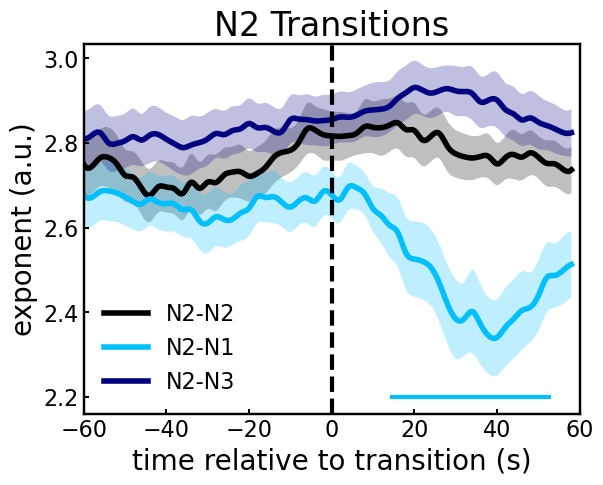

In [24]:
data1m = np.nanmean(N22m_a,axis=0)  # THIS IS THE N2 from the N2 vs N3 comparisons (prpoably highest number of trials)
data1s = stats.sem(N22m_a,0, nan_policy = 'omit')
    
data2m = np.nanmean(N21m_a,axis=0)
data2s = stats.sem(N21m_a,0, nan_policy = 'omit')

data3m = np.nanmean(N23m_a,axis=0)
data3s = stats.sem(N23m_a,0, nan_policy = 'omit')



xaxis = np.arange(-time_range,time_range,2)

# SMOOTHING
times=xaxis
xnew = np.linspace(times.min(),times.max(),1000)

# y values
spl = make_interp_spline(times, data1m, k=3) #BSpline object
s_counts1=spl(xnew)
#standard error
s1 = make_interp_spline(times, data1s, k=3) #BSpline object
s_sem1=s1(xnew)

# y values
spl = make_interp_spline(times, data2m, k=3) #BSpline object
s_counts2=spl(xnew)
#standard error
s2 = make_interp_spline(times, data2s, k=3) #BSpline object
s_sem2=s2(xnew)

# y values
spl = make_interp_spline(times, data3m, k=3) #BSpline object
s_counts3=spl(xnew)
#standard error
s3 = make_interp_spline(times, data3s, k=3) #BSpline object
s_sem3=s3(xnew)


fig, ax = plt.subplots()

ax.plot(xnew, s_counts1, 'k-', label='N2-N2',linewidth=4)
ax.fill_between(xnew, s_counts1-s_sem1, s_counts1+s_sem1,facecolor='k', alpha=0.25)

ax.plot(xnew, s_counts2, 'deepskyblue', label='N2-N1',linewidth=4)
ax.fill_between(xnew, s_counts2-s_sem2, s_counts2+s_sem2,facecolor='deepskyblue', alpha=0.25)

ax.plot(xnew, s_counts3, 'navy', label='N2-N3',linewidth=4)
ax.fill_between(xnew, s_counts3-s_sem3, s_counts3+s_sem3,facecolor='navy', alpha=0.25)

#ax.plot(xnew, s_counts4, 'cadetblue', label='N2-REM',linewidth=4)
#ax.fill_between(xnew, s_counts4-s_sem4, s_counts4+s_sem4,facecolor='cadetblue', alpha=0.25)

plt.legend(prop={'size': 16}, frameon=False)
plt.title('N2 Transitions', fontsize = 24)

# stats from matlab cluster-based permutation in fieldtrip
plt.hlines(y = 2.2, xmin = 14, xmax = 53, color='deepskyblue',linestyle='-',linewidth=3) 

plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('exponent (a.u.)', fontsize=20)
plt.xlabel('time relative to transition (s)', fontsize=20)
plt.xlim(-60, 60)
#plt.ylim(2.6, 3)
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)
#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_N2all_new.svg", dpi = 600 )

# NREM - REM transitions

In [43]:
i = 0

NNRm_a = np.zeros([17,time_range])*np.nan  # 30 data pooints means 30*2 = 60s should be centered at the time of transition
NRRm_a = np.zeros([17,time_range])*np.nan
trials = np.zeros(17)*np.nan
b =[2,3]

random.seed(0)
for x in np.arange(17):
    Stage = sfiles[x][~np.isnan(sfiles[x])] # load sleep stages
    param = A[x] # load parameter array
        
    # This section deals with the different stages and the transitions between them
    # First we wanted to see the transitions from N2
    NR_o = np.where(np.isin(Stage.astype(int), b))

    NR_o2 = np.reshape(NR_o, np.shape(NR_o)[1])

    # add 1 to the indices deteced above - in order to get the indices of the stage following N2 and look which sleep stage is it
    NR_l = np.array(Stage)[np.array([iii + 1 for iii in NR_o2[0:-1]])]
    
    NR_NR =np.where(np.isin(NR_l.astype(int), b))
    NR_NR2 =np.reshape(NR_NR, np.shape(NR_NR)[1])

    NR_R =np.where(np.isin(NR_l.astype(int), 5))
    NR_R2 =np.reshape(NR_R, np.shape(NR_R)[1])


    # Equalise the number of epcochs
    X = min(len(NR_NR2), len(NR_R2))
    trials[i] = X
    NR_NRa = random.sample(list(NR_NR2), X)
    NR_Ra = random.sample(list(NR_R2), X)
 
    NNt = [NR_o2[idx] for idx in NR_NRa] # select N1 epochs, now time zero is the time of transition
    NRt = [NR_o2[idx] for idx in NR_Ra] # select N3 epochs, now time zero is the time of transition
    
    # N2 to N3 transitions    
    NNR = np.zeros([len(NNt),time_range])*np.nan
    ii = 0
    for l in NNt:   
        NNR[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
    
    ii = 0
    NRR = np.zeros([len(NRt),time_range])*np.nan
    for l in NRt:
        NRR[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
        
    NNRm_a[i,0:time_range] = np.nanmean(NNR,axis=0)
    NRRm_a[i,0:time_range] = np.nanmean(NRR,axis=0)

    i = i+1

In [44]:
np.savetxt('/home/b1044271/Columbia/Results/Permutation/NREM_2-3_comp.txt', NNRm_a)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/REM_comp.txt', NRRm_a)

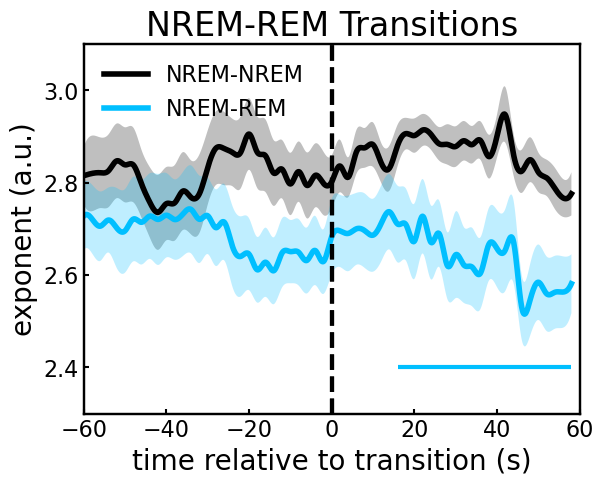

In [46]:
data1m = np.nanmean(NNRm_a,axis=0)  # THIS IS THE N2 from the N2 vs N3 comparisons (prpoably highest number of trials)
data1s = stats.sem(NNRm_a,0, nan_policy = 'omit')
    
data2m = np.nanmean(NRRm_a,axis=0)
data2s = stats.sem(NRRm_a,0, nan_policy = 'omit')

xaxis = np.arange(-time_range,time_range,2)

# SMOOTHING
times=xaxis
xnew = np.linspace(times.min(),times.max(),1000)

# y values
spl = make_interp_spline(times, data1m, k=3) #BSpline object
s_counts1=spl(xnew)
#standard error
s1 = make_interp_spline(times, data1s, k=3) #BSpline object
s_sem1=s1(xnew)

# y values
spl = make_interp_spline(times, data2m, k=3) #BSpline object
s_counts2=spl(xnew)
#standard error
s2 = make_interp_spline(times, data2s, k=3) #BSpline object
s_sem2=s2(xnew)


fig, ax = plt.subplots()

ax.plot(xnew, s_counts1, 'k-', label='NREM-NREM',linewidth=4)
ax.fill_between(xnew, s_counts1-s_sem1, s_counts1+s_sem1,facecolor='k', alpha=0.25)

ax.plot(xnew, s_counts2, 'deepskyblue', label='NREM-REM',linewidth=4)
ax.fill_between(xnew, s_counts2-s_sem2, s_counts2+s_sem2,facecolor='deepskyblue', alpha=0.25)



plt.legend(prop={'size': 16}, frameon=False)
plt.title('NREM-REM Transitions', fontsize = 24)

plt.hlines(y = 2.4, xmin = 16, xmax = 58, color='deepskyblue',linestyle='-',linewidth=3)

plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('exponent', fontsize=24)
plt.xlabel('time relative to transition (s)', fontsize=24)
plt.xlim(-60, 60)
plt.ylim(2.3, 3.1)
plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('exponent (a.u.)', fontsize=20)
plt.xlabel('time relative to transition (s)', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_NREM2-3_REM.svg", dpi = 600)

# N1 to N2 and Wake transitions

In [41]:
i = 0

N12m_a = np.zeros([17,time_range])*np.nan  # 30 data pooints means 30*2 = 60s should be centered at the time of transition
N11m_a = np.zeros([17,time_range])*np.nan
   
random.seed(0)    
for x in np.arange(17):
    Stage = sfiles[x][~np.isnan(sfiles[x])] # load sleep stages
    param = A[x] # load parameter array
        
    # This section deals with the different stages and the transitions between them
    # First we wanted to see the transitions from N2
    N1_o = [ii for ii in range(len(Stage)) if Stage.astype(int)[ii] == 1] # get N2 epochs 
    
    # add 1 to the indices deteced above - in order to get the indices of the stage following N2 and look which sleep stage is it
    N1_l = np.array(Stage)[np.array([iii + 1 for iii in N1_o[0:-2]])]
    
    NN1 = [iv for iv in range(len(N1_l)) if N1_l[iv] == 1] # get the indices of the N1 stages following N2
    NN2 = [iv for iv in range(len(N1_l)) if N1_l[iv] == 2] # get the indices of the N3 stages following N2
    
    NN12 = [x for x in NN1 if x > (time_range/t)]
    NN22 = [x for x in NN2 if x > (time_range/t)] 

    N11t = [N1_o[idx] for idx in NN12] # select N1 epochs, now time zero is the time of transition
    N12t = [N1_o[idx] for idx in NN22] # select N3 epochs, now time zero is the time of transition
    
    # Equalise the number of epcochs
    X = min(len(N11t), len(N12t))
    N11t2 = random.sample(N11t, X)
    N12t2 = random.sample(N12t, X)
    
    # N1 to N1 transitions    
    WW2 = np.zeros([len(N11t2),time_range])*np.nan
    ii = 0
    for l in N11t2:   
        WW2[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1

    # N1 to N1 transitions
    ii = 0
    WN2 = np.zeros([len(N12t2),time_range])*np.nan
    for l in N12t2:
        WN2[ii,0:time_range] = param[int(l-(time_range/t)): int(l+(time_range/t))]
        ii = ii+1
        
    N11m_a[i,0:time_range] = np.nanmean(WW2,axis=0)
    N12m_a[i,0:time_range] = np.nanmean(WN2,axis=0)

    i = i+1

In [49]:
np.savetxt('/home/b1044271/Columbia/Results/Permutation/N1_of_N1toN2comp.txt', N11m_a)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/N2_of_N1toN2comp.txt', N12m_a)

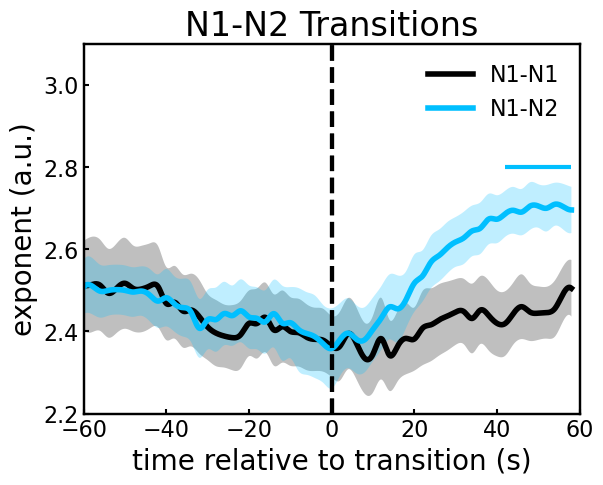

In [54]:
data1m = np.nanmean(N11m_a,axis=0)  # THIS IS THE N2 from the N2 vs N3 comparisons (prpoably highest number of trials)
data1s = stats.sem(N11m_a,0, nan_policy = 'omit')
    
data2m = np.nanmean(N12m_a,axis=0)
data2s = stats.sem(N12m_a,0, nan_policy = 'omit')

xaxis = np.arange(-time_range,time_range,2)

# SMOOTHING
times=xaxis
xnew = np.linspace(times.min(),times.max(),1000)

# y values
spl = make_interp_spline(times, data1m, k=3) #BSpline object
s_counts1=spl(xnew)
#standard error
s1 = make_interp_spline(times, data1s, k=3) #BSpline object
s_sem1=s1(xnew)

# y values
spl = make_interp_spline(times, data2m, k=3) #BSpline object
s_counts2=spl(xnew)
#standard error
s2 = make_interp_spline(times, data2s, k=3) #BSpline object
s_sem2=s2(xnew)


fig, ax = plt.subplots()

ax.plot(xnew, s_counts1, 'k-', label='N1-N1',linewidth=4)
ax.fill_between(xnew, s_counts1-s_sem1, s_counts1+s_sem1,facecolor='k', alpha=0.25)

ax.plot(xnew, s_counts2, 'deepskyblue', label='N1-N2',linewidth=4)
ax.fill_between(xnew, s_counts2-s_sem2, s_counts2+s_sem2,facecolor='deepskyblue', alpha=0.25)



plt.legend(prop={'size': 16}, frameon=False)
plt.title('N1-N2 Transitions', fontsize = 24)


plt.hlines(y = 2.80, xmin = 42, xmax = 58, color='deepskyblue',linestyle='-',linewidth=3)

plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('exponent', fontsize=24)
plt.xlabel('time relative to transition (s)', fontsize=24)
plt.xlim(-60, 60)
plt.ylim(2.2, 3.1)
plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('exponent (a.u.)', fontsize=20)
plt.xlabel('time relative to transition (s)', fontsize=20)

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_N1_N2.svg", dpi = 600)

# Now we move to Stimuli vs No stimuli

In [32]:
# get the files for the dummy NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/*DummyN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_dumN = np.ones([16,1250]) * np.nan

subj_files

array(['/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP01_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP03_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP04_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP05_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP06_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP07_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP08_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP10_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP11_DummyN_FOOOFed_MT.json',
       '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/VP12_Dummy

In [79]:
# get the files for the dummy NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/*DummyN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_dumN = np.ones([16,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_dumN[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the dummy REM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/*DummyR_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_dumR = np.ones([16,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_dumR[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/*StimsN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_stN = np.ones([16,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_stN[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the dummy REM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/*StimsR_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_stR = np.ones([16,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_stR[i,0:1250] = fm1.get_params('aperiodic_params','exponent')
    
    i=i+1

## baseline correction

In [48]:
time = np.load('/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/Time_5-5_MT.npy') # time vector -5 to 5 MT
# baseline correction


def perform_baseline(dataV, timeV, l_lim, h_lim):
    
    idx = (timeV>l_lim)*(timeV<h_lim) #get times
    bl = np.where(idx) # get indices of times in data
    dataN = np.ones(np.shape(dataV)) * np.nan
    
    for b in np.arange(np.shape(dataV)[0]):
        meanBL = np.nanmean(dataV[b,bl])

        for i in np.arange(np.shape(dataV)[1]):
        
            dataN[b,i] = (dataV[b,i]-meanBL)/meanBL
            
    return(dataN)


StN_BL = perform_baseline(Exp_stN,time, -0.5,0)
StR_BL = perform_baseline(Exp_stR,time, -0.5,0)
DmN_BL = perform_baseline(Exp_dumN,time, -0.5,0)
DmR_BL = perform_baseline(Exp_dumR,time, -0.5,0)

In [49]:
# Adjust matrices
ESNm = np.nanmean(StN_BL,axis=0)
ESNs = stats.sem(StN_BL,0, nan_policy = 'omit')

ESRm = np.nanmean(StR_BL,axis=0)
ESRs = stats.sem(StR_BL,0, nan_policy = 'omit')

EDNm = np.nanmean(DmN_BL,axis=0)
EDNs = stats.sem(DmN_BL,0, nan_policy = 'omit')#[100:1190]

EDRm = np.nanmean(DmR_BL,axis=0)
EDRs = stats.sem(DmR_BL,0, nan_policy = 'omit')#[100:1190]


# combine both
StNR = np.concatenate((StN_BL, StR_BL ), axis = 0)
DmNR = np.concatenate((DmN_BL, DmR_BL ), axis = 0)

# adjust
AllSm = np.nanmean(StNR,axis=0)
AllSs = stats.sem(StNR,0, nan_policy = 'omit')

AllDm = np.nanmean(DmNR,axis=0)
AllDs = stats.sem(DmNR,0, nan_policy = 'omit')

In [50]:
STIM_all  = np.mean(np.dstack((StN_BL, StR_BL)),2)
DUMM_all  = np.mean(np.dstack((DmN_BL, DmR_BL)),2)

np.savetxt('/home/b1044271/Columbia/Results/Permutation/Stims_all.txt', STIM_all)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/Dummy_all.txt', DUMM_all)

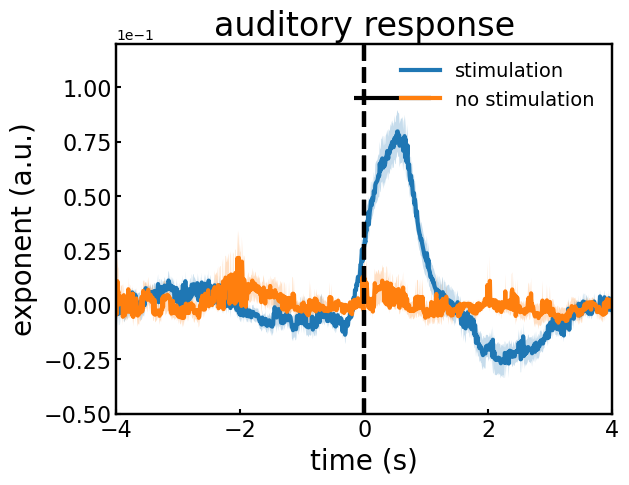

In [51]:
plt.plot(time, ESNm ,color='tab:blue',linestyle='-',linewidth=3, label = 'stimulation')
plt.fill_between(time,ESNm -ESNs, ESNm+ESNs,facecolor='tab:blue', alpha=0.25)
plt.legend(prop={'size': 14}, frameon=False)

plt.plot(time, EDNm ,color='tab:orange',linestyle='-',linewidth=3, label = 'no stimulation')
plt.fill_between(time,EDNm -EDNs, EDNm+EDNs,facecolor='tab:orange', alpha=0.25)

plt.legend(prop={'size': 14}, frameon=False)
plt.title("auditory response", fontsize = 24)
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth =3)
plt.hlines(y = 0.095, xmin = time[604], xmax = time[760], color='k',linestyle='-',linewidth=3)

plt.xlim(-4,4)
plt.ylim(-0.05,0.12)
plt.ylabel("exponent", fontsize = 24)
plt.xlabel("time (s)", fontsize = 24)

plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('exponent', fontsize=24)
plt.xlabel('time relative to transition (s)', fontsize=24)

plt.axvline(x= 0, color='k',linestyle='--',linewidth=3)
plt.ylabel('exponent (a.u.)', fontsize=20)
plt.xlabel('time (s)', fontsize=20)

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)

ax.ticklabel_format(axis='y', scilimits=[-0.05, 0.1])

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_Stims_all.svg", dpi = 600)

# KC vs NO KC

In [101]:
# get the files for the no K-complex
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/E257/Transitions/Multitaper/*StimNoKC_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_snKC = np.ones([17,1250]) * np.nan
Knee_snKC = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_snKC[i,0:1250] = fm1.get_params('aperiodic_params','exponent')
    Knee_snKC[i,0:1250] = fm1.get_params('aperiodic_params','knee')

    i=i+1
    
# get the files for K-complexes
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/E257/Transitions/Multitaper/*StimKC_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_sKC = np.ones([17,1250]) * np.nan
Knee_sKC = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_sKC[i,0:1250] = fm1.get_params('aperiodic_params','exponent')
    Knee_sKC[i,0:1250] = fm1.get_params('aperiodic_params','knee')

    i=i+1

## Baseline correction

In [102]:
time = np.load('/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/Time_5-5_MT.npy') # time vector -5 to 5 MT
# baseline correction

KC_BL = perform_baseline(Exp_sKC,time, -0.5,0)
NKC_BL = perform_baseline(Exp_snKC,time, -0.5,0)


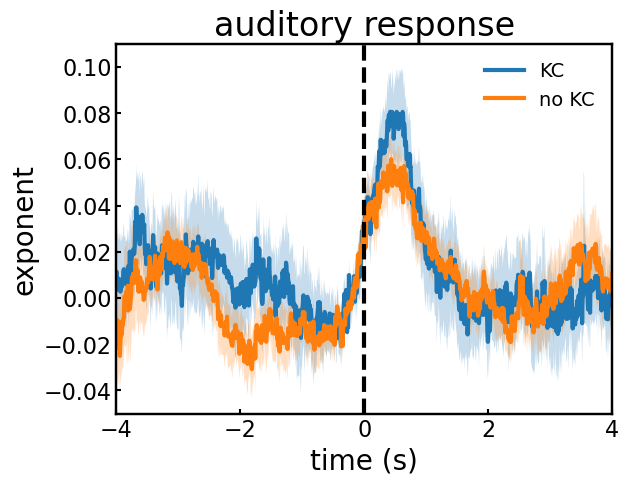

In [121]:
K_K_O = np.nanmean(KC_BL,axis=0)[100:1190]
K_K_Os = stats.sem(KC_BL,0, nan_policy = 'omit')[100:1190]
time = np.load('/home/b1044271/Columbia/Results/Time-resolved/E257/Transitions/Multitaper/Times.npy')
plt.plot(time[725:1815], K_K_O ,color='tab:blue',linestyle='-',linewidth=3, label = 'KC')
plt.fill_between(time[725:1815],K_K_O -K_K_Os, K_K_O+K_K_Os,facecolor='tab:blue', alpha=0.25)
plt.legend(prop={'size': 14}, frameon=False)


K_K_On = np.nanmean(NKC_BL,axis=0)[100:1190]
K_K_Osn = stats.sem(NKC_BL,0, nan_policy = 'omit')[100:1190]
time = np.load('/home/b1044271/Columbia/Results/Time-resolved/E257/Transitions/Multitaper/Times.npy')
plt.plot(time[725:1815], K_K_On ,color='tab:orange',linestyle='-',linewidth=3, label = 'no KC')
plt.fill_between(time[725:1815],K_K_On -K_K_Osn, K_K_On+K_K_Osn,facecolor='tab:orange', alpha=0.25)
plt.legend(prop={'size': 14}, frameon=False)
plt.title("auditory response", fontsize = 24)
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth = 3)
plt.xlim(-4,4)
plt.ylim(-0.05,0.11)
plt.ylabel("exponent", fontsize =20)
plt.xlabel("time (s)", fontsize = 20)
plt.xticks(fontsize=20)

ax=plt.gca()

ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_KCN2.svg", dpi = 600)

# Stimulus categories

## FV vs UFV

In [122]:
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_FVN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_FVN = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_FVN[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_UFVN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_UFVN = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_UFVN[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_FVR_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_FVR = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_FVR[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_UFVR_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_UFVR = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_UFVR[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1

## SON vs UNs

In [124]:
# SON and UN
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_SONN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_SONN = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_SONN[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_UNN_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_UNN = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_UNN[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_SONR_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_SONR = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_SONR[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1
    
# get the files for the FV NREM markers
Data_path = '/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/Cat/*_UNR_FOOOFed_MT.json'
subj_files = np.sort(glob.glob(Data_path))
Exp_UNR = np.ones([17,1250]) * np.nan

i=0
for x in subj_files:

    fm1 = FOOOFGroup()
    fm1.load(x)
    Exp_UNR[i,0:1250] = fm1.get_params('aperiodic_params','exponent')

    i=i+1

In [128]:
#baseline correction
SONN_BL = perform_baseline(Exp_SONN,time, -0.5,0)
UNN_BL = perform_baseline(Exp_UNN,time, -0.5,0)
SONR_BL = perform_baseline(Exp_SONR,time, -0.5,0)
UNR_BL = perform_baseline(Exp_UNR,time, -0.5,0)

FVN_BL = perform_baseline(Exp_FVN,time, -0.5,0)
UFVN_BL = perform_baseline(Exp_UFVN,time, -0.5,0)
FVR_BL = perform_baseline(Exp_FVR,time, -0.5,0)
UFVR_BL = perform_baseline(Exp_UFVR,time, -0.5,0)

In [129]:
# Mean of REM and NREM stims
SONNm = np.nanmean(SONN_BL,axis=0)
SONNs = stats.sem(SONN_BL,0, nan_policy = 'omit')

UNNm = np.nanmean(UNN_BL,axis=0)
UNNs = stats.sem(UNN_BL,0, nan_policy = 'omit')

SONRm = np.nanmean(SONR_BL,axis=0)
SONRs = stats.sem(SONR_BL,0, nan_policy = 'omit')#[100:1190]

UNRm = np.nanmean(UNR_BL,axis=0)
UNRs = stats.sem(UNR_BL,0, nan_policy = 'omit')#[100:1190]

# combine both
FVNR = np.concatenate((FVN_BL, FVR_BL ), axis = 0)
UFVNR = np.concatenate((UFVN_BL, UFVR_BL ), axis = 0)
SONNR = np.concatenate((SONN_BL, SONR_BL ), axis = 0)
UNNR = np.concatenate((UNN_BL, UNR_BL ), axis = 0)
# adjust
AllFVm = np.nanmean(FVNR,axis=0)
AllFVs = stats.sem(FVNR,0, nan_policy = 'omit')

AllUFVm = np.nanmean(UFVNR,axis=0)
AllUFVs = stats.sem(UFVNR,0, nan_policy = 'omit')

AllSONm = np.nanmean(SONNR,axis=0)
AllSONs = stats.sem(SONNR,0, nan_policy = 'omit')

AllUNm = np.nanmean(UNNR,axis=0)
AllUNs = stats.sem(UNNR,0, nan_policy = 'omit')

In [147]:
FV_all  = np.mean(np.dstack((FVN_BL, FVR_BL)),2)
UFV_all  = np.mean(np.dstack((UFVN_BL, UFVR_BL)),2)
SON_all  = np.mean(np.dstack((SONN_BL, SONR_BL)),2)
UN_all  = np.mean(np.dstack((UNN_BL, UNR_BL)),2)

np.savetxt('/home/b1044271/Columbia/Results/Permutation/FV_all.txt', FV_all)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/UFV_all.txt', UFV_all)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/SON_all.txt', SON_all)
np.savetxt('/home/b1044271/Columbia/Results/Permutation/UN_all.txt', UN_all)

In [133]:
# adjust for plotting
AllFVm = np.nanmean(FV_all,axis=0)
AllFVs = stats.sem(FV_all,0, nan_policy = 'omit')

AllUFVm = np.nanmean(UFV_all,axis=0)
AllUFVs = stats.sem(UFV_all,0, nan_policy = 'omit')

AllSONm = np.nanmean(SON_all,axis=0)
AllSONs = stats.sem(SON_all,0, nan_policy = 'omit')

AllUNm = np.nanmean(UN_all,axis=0)
AllUNs = stats.sem(UN_all,0, nan_policy = 'omit')

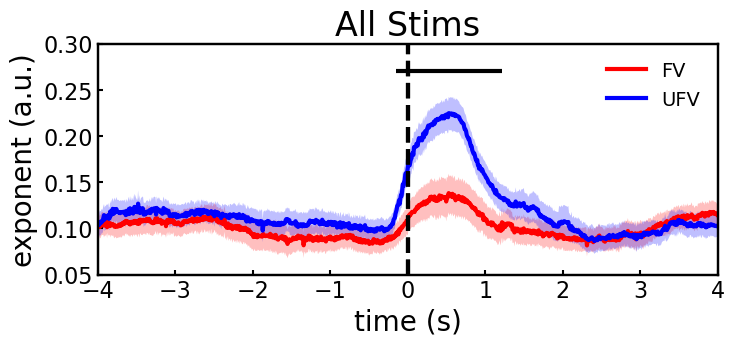

In [156]:
time = np.load('/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/Time_5-5_MT.npy') # time vector -5 to 5 MT

plt.figure(figsize=(8,3))  


plt.plot(time, AllFVm ,color='red',linestyle='-',linewidth=3, label = 'FV')
plt.fill_between(time,AllFVm -AllFVs, AllFVm+AllFVs,facecolor='red', alpha=0.25)
plt.legend(prop={'size': 14}, frameon=False)

plt.plot(time, AllUFVm ,color='blue',linestyle='-',linewidth=3, label = 'UFV')
plt.fill_between(time,AllUFVm -AllUFVs, AllUFVm+AllUFVs,facecolor='blue', alpha=0.25)

plt.legend(prop={'size': 14}, frameon=False)
plt.title("All Stims", fontsize = 24)
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth =3)

plt.hlines(y = 0.27, xmin = time[606], xmax = time[777], color='k',linestyle='-',linewidth=3)

plt.xlim(-4,4)
plt.ylim(0.05,0.3)
plt.ylabel("exponent", fontsize = 24)
plt.xlabel("time (s)", fontsize = 24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth = 3)
plt.ylabel("exponent (a.u.)", fontsize =20)
plt.xlabel("time (s)", fontsize = 20)
plt.xticks(fontsize=20)

ax=plt.gca()

ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_FVUFV_All.svg", dpi = 600)

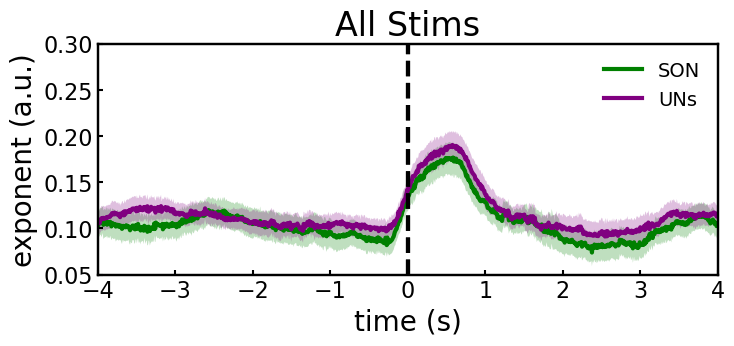

In [157]:
time = np.load('/home/b1044271/Columbia/Results/Time-resolved/Transitions/Cz/MT/Time_5-5_MT.npy') # time vector -5 to 5 MT

plt.figure(figsize=(8,3))  

plt.plot(time, AllSONm ,color='green',linestyle='-',linewidth=3, label = 'SON')
plt.fill_between(time,AllSONm -AllSONs, AllSONm+AllSONs,facecolor='green', alpha=0.25)
plt.legend(prop={'size': 14}, frameon=False)

plt.plot(time, AllUNm ,color='purple',linestyle='-',linewidth=3, label = 'UNs')
plt.fill_between(time,AllUNm -AllUNs, AllUNm+AllUNs,facecolor='purple', alpha=0.25)

plt.legend(prop={'size': 14}, frameon=False)
plt.title("All Stims", fontsize = 24)
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth =3)
 

plt.xlim(-4,4)
plt.ylim(0.05,0.3)
plt.ylabel("exponent", fontsize = 24)
plt.xlabel("time (s)", fontsize = 24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth = 3)
plt.ylabel("exponent (a.u.)", fontsize =20)
plt.xlabel("time (s)", fontsize = 20)
plt.xticks(fontsize=20)

ax=plt.gca()

ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
ax.spines['right'].set_linewidth(1.75)
ax.spines['top'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV23/TR_SONUN_All.svg", dpi = 600)